# Neural Network approach

## libraries

In [2]:
import pandas as pd
import numpy as np
import os
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Reading data

In [3]:
# Connect to your google drive:
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/AirfoilData/")

data = pd.read_csv('combined-naca.csv')
#features = pd.read_csv('naca0021.csv')
data.head(5)
print('The shape of our features is:', data.shape)
# Descriptive statistics for each column
data.describe()

Mounted at /content/drive/
The shape of our features is: (3652, 8)


,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.764239,0.253072,0.022089,0.016955,-0.041006,0.525791,0.561634,2310.521632
std,10.562997,0.967161,0.021333,0.021750,0.043580,0.397649,0.435943,1876.249303
min,-19.750000,-1.564400,0.003380,0.000730,-0.157400,0.003300,0.003200,6.000000
25%,-8.000000,-0.633650,0.008778,0.003210,-0.065600,0.074575,0.065575,21.000000
50%,1.000000,0.320150,0.013440,0.007820,-0.036300,0.537050,0.684850,2412.000000
75%,9.750000,1.202625,0.025755,0.020650,-0.004800,0.972025,1.000000,4412.000000
max,19.250000,1.708400,0.151610,0.149750,0.043200,1.000000,1.000000,6412.000000


In [4]:
data.sample(n=10)

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca
1188,-10.25,-0.4049,0.01204,0.00647,-0.1450,0.8466,0.1344,4424
29,-8.50,-0.9485,0.01286,0.00726,0.0022,1.0000,0.0145,9
2494,14.00,1.4279,0.02653,0.02131,0.0070,0.0214,1.0000,1412
3462,10.75,1.2498,0.01642,0.01085,-0.0163,0.1794,1.0000,2421
2902,-16.50,-1.2790,0.04253,0.03904,-0.0630,1.0000,0.0146,2412
3624,12.50,1.2377,0.02497,0.01973,0.0082,0.1870,1.0000,2424
1999,-8.25,-0.9383,0.01216,0.00619,0.0028,0.9944,0.0722,15
37,-6.50,-0.7737,0.01089,0.00524,0.0114,1.0000,0.0321,9
278,18.50,1.3766,0.05951,0.05452,0.0410,0.0590,1.0000,21
1551,-6.00,-0.6461,0.01480,0.01001,-0.0037,1.0000,0.0061,6


## Splitting NACA digits

In [5]:
data['Naca_1st'] = data['Naca'] // 1000
data['Naca_2nd'] = (data['Naca'] % 1000) // 100
data['Naca_3rd'] = data['Naca'] % 100
data.sample(n=10)

,Alpha,Cl,Cd,Cdp,Cm,Top_Xtr,Bot_Xtr,Naca,Naca_1st,Naca_2nd,Naca_3rd
2375,-16.00,-1.3694,0.03428,0.03007,-0.0505,1.0000,0.0145,1412,1,4,12
2289,-4.00,-0.3430,0.00825,0.00267,-0.0235,0.9917,0.0368,1408,1,4,8
2966,-0.25,0.2173,0.00573,0.00121,-0.0527,0.6799,0.6158,2412,2,4,12
212,1.75,0.1886,0.00807,0.00246,0.0020,0.4359,0.6037,21,0,0,21
739,-12.25,-0.8320,0.01520,0.00979,-0.1104,0.9546,0.0458,4418,4,4,18
1003,-18.75,-1.0541,0.06308,0.05892,-0.0990,1.0000,0.0449,4421,4,4,21
3235,-8.75,-0.6982,0.01147,0.00579,-0.0591,0.9271,0.0953,2418,2,4,18
157,-12.75,-1.2204,0.01920,0.01346,-0.0303,1.0000,0.1004,21,0,0,21
560,17.00,1.5231,0.05372,0.04864,-0.0029,0.0320,1.0000,2415,2,4,15
1788,14.75,1.3695,0.03335,0.02935,0.0273,0.0080,1.0000,10,0,0,10


## Training, test and validation sets split 

In [8]:
# get the list of all NACAs in dataset
uniqueNACAs = data.Naca.unique()
print('Unique NACAs: ', uniqueNACAs, '\n\nin total: ', len(uniqueNACAs))

# choose how big should be the training and test set
trainSetShare = 0.6
testSetShare = 0.2

# calculate how many NACA profiles will be in each subset
trainSetSize = int(trainSetShare * len(uniqueNACAs))
testSetSize = int(testSetShare * len(uniqueNACAs))
validSetSize = len(uniqueNACAs) - testSetSize - trainSetSize

print(f'\nSubset sizes:\n - training set: {trainSetSize}\n - test set: {testSetSize}\n - validation set: {validSetSize}\n\n\n')

# shuffle unique NACAs list to randomize the subsets division
np.random.shuffle(uniqueNACAs)

# divide the subsets
trainNACAs = uniqueNACAs[:trainSetSize]
testNACAs = uniqueNACAs[trainSetSize:trainSetSize+testSetSize]
validNACAs = uniqueNACAs[trainSetSize+testSetSize:]

print(f'- training set - {np.sort(trainNACAs)}')
print(f'- test set - {np.sort(testNACAs)}')
print(f'- validation set - {np.sort(validNACAs)}')

Unique NACAs:  [   9   21 1410 2415 4415 4418 4412 4421 4424 6409 6412    6    8   10
   12   15   18 1408 1412 2408 2410 2411 2412 2414 2418 2421 2424] 

in total:  27

Subset sizes:
 - training set: 16
 - test set: 5
 - validation set: 6



- training set - [   9   10   12   15   18   21 1408 1410 2410 2412 2418 2424 4412 4415
 6409 6412]
- test set - [1412 2411 2415 4418 4421]
- validation set - [   6    8 2408 2414 2421 4424]


In [9]:
# Dividing all data into subsets
trainSet = data.loc[data['Naca'].isin(trainNACAs)]
testSet = data.loc[data['Naca'].isin(testNACAs)]
validSet = data.loc[data['Naca'].isin(validNACAs)]

## Feature and target extraction

In [10]:
featuresNames = ['Alpha', 'Naca_1st', 'Naca_2nd', 'Naca_3rd']
targetsNames = ['Cl', 'Cd', 'Cdp', 'Cm', 'Top_Xtr', 'Bot_Xtr']

# Dividing features and targets/labels
X_train = trainSet[featuresNames]
Y_train = trainSet[targetsNames]

X_test = testSet[featuresNames]
Y_test = testSet[targetsNames]

X_valid = validSet[featuresNames]
Y_valid = validSet[targetsNames]

X_test

,Alpha,Naca_1st,Naca_2nd,Naca_3rd
421,-19.00,2,4,15
422,-18.75,2,4,15
423,-18.50,2,4,15
424,-18.25,2,4,15
425,-18.00,2,4,15
...,...,...,...,...
2893,18.00,2,4,11
2894,18.25,2,4,11
2895,18.50,2,4,11
2896,18.75,2,4,11


## draft neural network for 1st target - lift coefficient (Cl)


## NN definition

In [ ]:
# Defining a model with 1  layer

input_shape = [features.shape[1]]

model1_Cl = keras.Sequential([
    # the hidden layer using ReLU activation function, 10 neurons in a layer
    layers.Dense(units=10, activation='relu', input_shape=input_shape),
    layers.Dense(units=10, activation='relu', input_shape=input_shape),
    layers.Dense(units=10, activation='relu', input_shape=input_shape),
    # the linear output layer 
    layers.Dense(units=1),
])

In [ ]:
# Defining early stop for when the loss is already converged
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model1_Cl.compile(
    optimizer='adam',
    loss='mse',
)

## Training

In [ ]:
history = model1_Cl.fit(
    features, targets['Cl'],
    # validation_data=(X_valid, y_valid),
    batch_size=10,
    callbacks=[early_stopping],
    epochs=10,
)

Epoch 1/10
366/366 [==============================] - 1s 2ms/step - loss: 1.6708
Epoch 2/10
366/366 [==============================] - 1s 2ms/step - loss: 0.0448
Epoch 3/10
366/366 [==============================] - 1s 2ms/step - loss: 0.0308
Epoch 4/10
366/366 [==============================] - 1s 2ms/step - loss: 0.0236
Epoch 5/10
366/366 [==============================] - 1s 1ms/step - loss: 0.0194
Epoch 6/10
366/366 [==============================] - 1s 2ms/step - loss: 0.0175
Epoch 7/10
366/366 [==============================] - 1s 1ms/step - loss: 0.0166
Epoch 8/10
366/366 [==============================] - 1s 1ms/step - loss: 0.0154
Epoch 9/10
366/366 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 10/10
366/366 [==============================] - 1s 1ms/step - loss: 0.0134


 ## checking the neural network training loss

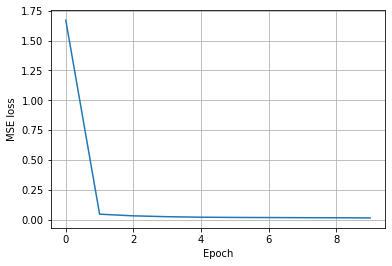

In [ ]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();
plt.grid();
plt.ylabel('MSE loss');
plt.xlabel('Epoch');

## Making a prediction

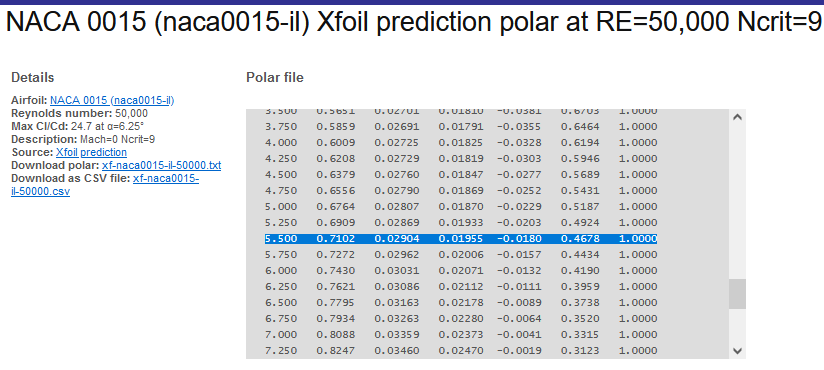

In [ ]:
# input data
alphaPredict = 5.5  # Must be float number!!!!
NACApredict_1 = 0 
NACApredict_2 = 0
NACApredict_3 = 15

inputToPredict = pd.DataFrame(columns=features.columns)
inputToPredict.loc[0] = [alphaPredict, NACApredict_1, NACApredict_2, NACApredict_3]
print(inputToPredict)
# inputToPredict = [alphaPredict, NACApredict_1, NACApredict_2, NACApredict_3]

# Making a prediction 
prediction_Cl = model1_Cl.predict(inputToPredict)

print(f'Lift coefficient for NACA{NACApredict_1}{NACApredict_2}{NACApredict_3} at attack angle alpha = {alphaPredict} - Cl = {prediction_Cl[0][0]}')

   Alpha  Naca_1st  Naca_2nd  Naca_3rd
0    5.5       0.0       0.0      15.0
Lift coefficient for NACA0015 at attack angle alpha = 5.5 - Cl = 0.6502602100372314


## Plotting a Cl polar curve


NACA2410  


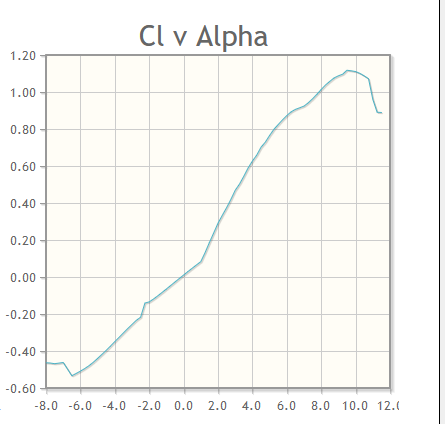

Text(0.5, 1.0, 'Cl v Alpha')

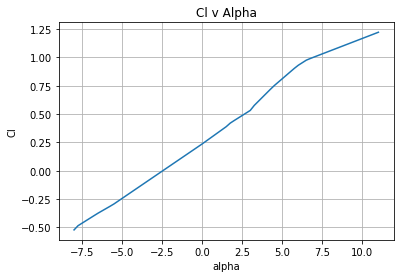

In [ ]:
# input data
alphaRange = np.arange(-8.0, 11.1, 0.25)
NACApredict_1 = 2
NACApredict_2 = 4
NACApredict_3 = 10

inputToPredict = pd.DataFrame(columns=features.columns) 
for i in range(len(alphaRange)):
  inputToPredict.loc[i] = [alphaRange[i], NACApredict_1, NACApredict_2, NACApredict_3]

# Making a prediction 
prediction_polarCurve = model1_Cl.predict(inputToPredict)
np.squeeze(prediction_polarCurve) # removing of a dimension equal to 1 (from (77,1) to (77,)  )

plt.figure()
plt.plot(alphaRange, prediction_polarCurve)
plt.grid();
plt.xlabel('alpha');
plt.ylabel('Cl');
plt.title('Cl v Alpha')
